In [ ]:
import sys
import numpy as np
import netCDF4 as nc
import xarray as xr
import ast
import pandas as pd
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
coastline = cfeature.GSHHSFeature(scale='full',levels=[1]) 
# The dataset scale. One of ‘auto’, ‘coarse’, ‘low’, ‘intermediate’, ‘high, or ‘full’ (default is ‘auto’).
import warnings
warnings.simplefilter('ignore')

ds_path = '/Users/opticslab/Documents/BIOSCAPE/OLCI/polymer_out/p_out'


#NEW coastal
c1 = -0.27036093; c2 = 3.44358941; c3 = -3.8377943; c4 = -0.06177415; c5 = 1.15006086; c6 = 4.227966776705502

#New costal + inland s275
d1 = -0.17042979; d2 = 1.43449794; d3 = -1.68159208; d4 = 0.69000059; d5 = -0.28499721; d6 = -4.233559628382057


# bands = ['Rw400','Rw412','Rw443', 'Rw490', 'Rw510', 'Rw560', 'Rw620', 'Rw665', 'Rw674', 'Rw681']


def preprocess(ds):     
    band_num = ast.literal_eval(ds.bands_rw)
    bands = ['Rw' + str(i) for i in band_num]    
     
    ds_new =  xr.Dataset(
        {'Rrs_400': xr.DataArray(
            data = ds.variables[bands[0]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
        
         'Rrs_412': xr.DataArray(
            data = ds.variables[bands[1]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
        
        'Rrs_443': xr.DataArray(
            data = ds.variables[bands[2]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
         
        'Rrs_490': xr.DataArray(
            data = ds.variables[bands[3]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
         
        'Rrs_510': xr.DataArray(
            data = ds.variables[bands[4]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),

        'Rrs_560': xr.DataArray(
            data = ds.variables[bands[5]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
         
         'Rrs_620': xr.DataArray(
            data = ds.variables[bands[6]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),

        'Rrs_665': xr.DataArray(
            data = ds.variables[bands[7]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),

        'Rrs_674': xr.DataArray(
            data = ds.variables[bands[8]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'}),
         
        'Rrs_682': xr.DataArray(
            data = ds.variables[bands[9]]/np.pi, dims=['height', 'width'], coords={'Date':pd.to_datetime(ds.start_time.split(' ')[0]), 'lat':ds.variables['latitude'][:], 'lon':ds.variables['longitude'][:]}, attrs  = {'units':'sr^-1'})})
         
    return ds_new

def cdom_calc(rrs_443, rrs_490, rrs_510, rrs_560, rrs_665):
    ag300 = np.exp(c1 * np.log(rrs_443) + c2 * np.log(rrs_490) +
                      c3 * np.log(rrs_510) + c4 * np.log(rrs_560) +
                      c5 * np.log(rrs_665) + c6)
    return ag300


def s275_calc(rrs_443, rrs_490, rrs_510, rrs_560, rrs_665):
    s275 = np.exp(d1 * np.log(rrs_443) + d2 * np.log(rrs_490) +
                      d3 * np.log(rrs_510) + d4 * np.log(rrs_560) +
                      d5 * np.log(rrs_665) + d6)
    return s275

## OC4 OLCI coefficients
a0 = 0.42540; a1 = -3.21679; a2 = 2.86907; a3 = -00.62628; a4 = -1.09333


def oc4_calc(rrs_443, rrs_490, rrs_510,rrs_560):
    
    X = np.log10( np.nanmax([rrs_443, rrs_490, rrs_510], axis=0) / rrs_560)
    
    chl = 10 ** (a0 + a1 * X + a2 * X **2 + a3 * X**3 + a4 * X ** 4)
    return chl


flist = sorted(glob.glob(f'{ds_path}/S*'))

olci = xr.open_mfdataset(flist,  preprocess=preprocess, concat_dim='Date',combine='nested')


bands = ['Rrs_400','Rrs_412','Rrs_443', 'Rrs_490', 'Rrs_510', 'Rrs_560', 'Rrs_620', 'Rrs_665', 'Rrs_674', 'Rrs_682']

olci[bands] = olci[bands].where(olci[bands]>0)
olci = olci.assign(cdom = lambda olci: cdom_calc(olci.Rrs_443, olci.Rrs_490, olci.Rrs_510, olci.Rrs_560, olci.Rrs_665))
olci = olci.assign(s275 = lambda olci: s275_calc(olci.Rrs_443, olci.Rrs_490, olci.Rrs_510, olci.Rrs_560, olci.Rrs_665))
olci = olci.assign(chl = lambda olci: oc4_calc(olci.Rrs_443, olci.Rrs_490, olci.Rrs_510,olci.Rrs_560))


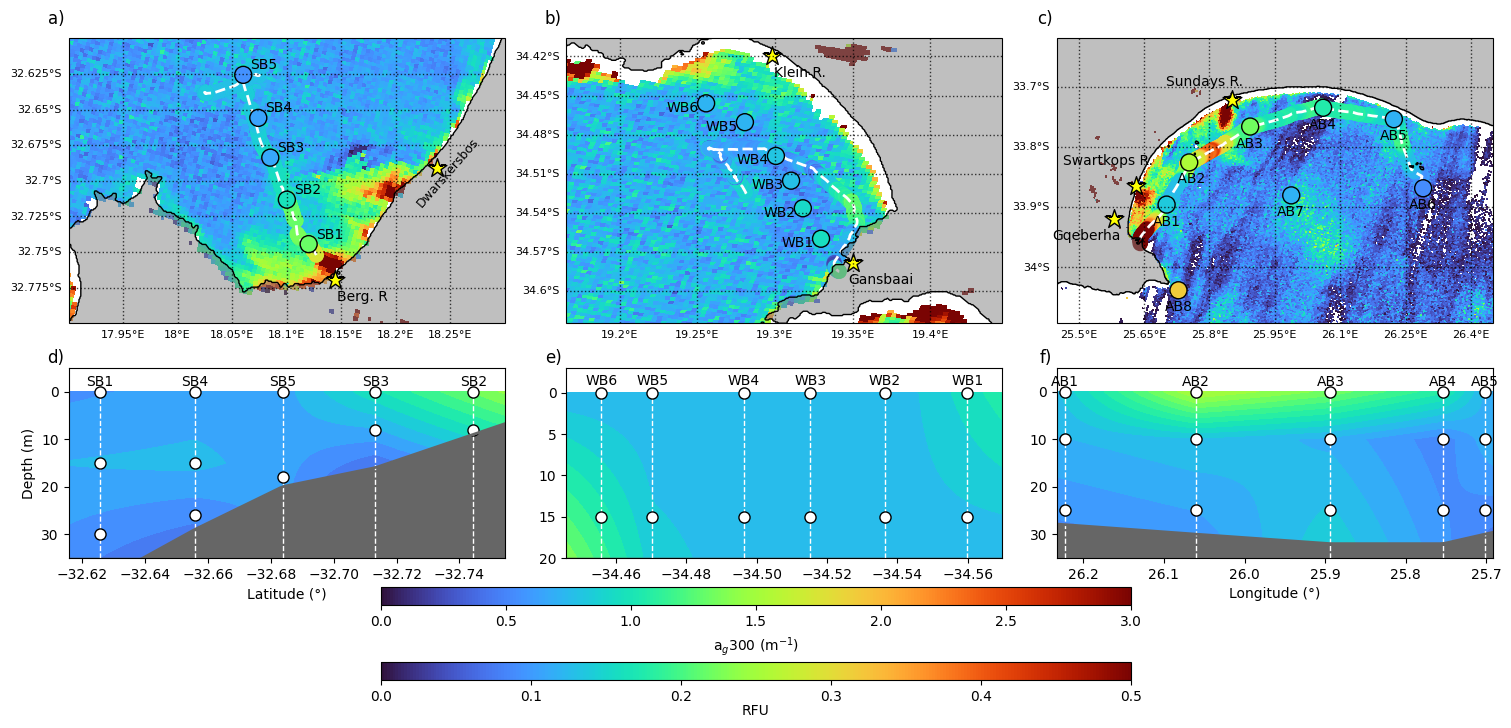

FileNotFoundError: [Errno 2] No such file or directory: '/Users/opticslab/Desktop/Catipovic_JGR_2025_figures/Catipovic_JGRBiogeosciences_2025_Figure5.png'

In [ ]:


ab_olci = olci.sel(Date=olci.Date[1])
shb_olci  = olci.sel(Date=olci.Date[0])
wb_olci = olci.sel(Date=olci.Date[2])

fdom_shb = pd.read_excel('BIOSCAPE-2023-ALF-FCDOM.xls',sheet_name='ST-HELENA-BAY-DAY1&2')
fdom_wb = pd.read_excel('BIOSCAPE-2023-ALF-FCDOM.xls',sheet_name='WALKER-BAY-DAY1&2')
fdom_ab = pd.read_excel('BIOSCAPE-2023-ALF-FCDOM.xls',sheet_name='ALGOA-BAY-DAY2-ALF')

shb_lat_fdom = fdom_shb.Latitude
shb_lon_fdom = fdom_shb.Longitude
shb_fcdom = fdom_shb.FCDOM


fig = plt.figure(figsize=(15,6),layout = "compressed")
gs = fig.add_gridspec(2, 3, height_ratios=[1.5, 1])

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(),aspect="auto")
ax1.set_extent([18.3,17.9, -32.8, -32.6], crs=ccrs.PlateCarree())
ax1.add_feature(coastline, ec=(0,0,0,1),fc=(0.5,0.5,0.5,0.5))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               linewidth=1, color='k', alpha=0.75, linestyle=':')
    
gl.top_labels=False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(), aspect="auto")
ax2.set_extent([19.446512,19.165716, -34.624719, -34.406115], crs=ccrs.PlateCarree())
ax2.add_feature(coastline, ec=(0,0,0,1),fc=(0.5,0.5,0.5,0.5))
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               linewidth=1, color='k', alpha=0.75, linestyle=':')
    
gl.top_labels=False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}


ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree(),aspect="auto")

ax3.set_extent([25.45,26.45, -33.62, -34.092873], crs=ccrs.PlateCarree())
ax3.add_feature(coastline, ec=(0,0,0,1),fc=(0.5,0.5,0.5,0.5))
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               linewidth=1, color='k', alpha=0.75, linestyle=':')
    
gl.top_labels=False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}



#######################
#######################
vmin=0
vmax=3
s = 150
#######################
#######################


cs1=ax1.pcolormesh(shb_olci.lon, shb_olci.lat, shb_olci.cdom, cmap='turbo', vmin=vmin, vmax=vmax)
cs2=ax2.pcolormesh(wb_olci.lon, wb_olci.lat, wb_olci.cdom, cmap='turbo', vmin=vmin, vmax=vmax)
cs3=ax3.pcolormesh(ab_olci.lon, ab_olci.lat, ab_olci.cdom, cmap='turbo', vmin=vmin, vmax=vmax)



SHB_lat = [-32.7444,  -32.7132,  -32.6837,  -32.6558,  -32.6256]
SHB_lon = [18.1202,   18.1002,   18.0850,   18.0740,   18.0602]
SHB_lbs = ['SB1', 'SB2', 'SB3', 'SB4', 'SB5']
SHB_acdom = [1.31227841731321, 0.975087205401794, 0.657260706835852, 0.636114338205783, 0.552125785693884]


WB_lat = [-34.5598025, -34.53643167,-34.51526167, -34.496295, -34.4704083, -34.4559425	]
WB_lon = [19.32974,19.318015, 19.310449167, 19.3006783, 19.28072167, 19.2557475]
WB_lbs = ['WB1', 'WB2', 'WB3', 'WB4', 'WB5','WB6']
WB_acdom = [0.949834354743192,0.917683818810945,0.779959674832484, 0.797997728209027, 0.716700299631845, 0.722385101549357]


#AB_lbs = ['EO0',' EO1','EO2','EO3','P2','P3','P4','P5','P6','P7','P8']
AB_lbs = ['AB1',' AB2','AB3','AB4','AB5','AB6','AB7','AB8']

AB_lat = [-33.8958, -33.82585,-33.766318, -33.73517,-33.754123,-33.868695, -33.880513, -34.03797]
AB_lon = [ 25.7019, 25.753738, 25.89355, 26.060795, 26.222993,26.29019167, 25.9876683, 25.729173]
AB_acdom = [0.826758777125947, 1.53588471288776, 1.33304182160711, 1.06017079430710, 0.707161843833811, 0.536706319523313, 0.703256377261672, 1.90619513552368]



##-- Plot fdom scatter lines-------------------------------------------

ax1.scatter(shb_lon_fdom,shb_lat_fdom, c=shb_fcdom.to_numpy(), s=100, vmin = 0,vmax = 0.5, cmap='turbo',marker='o',edgecolors = None)
ax1.plot(shb_lon_fdom, shb_lat_fdom, '--w', linewidth=2, zorder=1)

#----------------------------------------------------------------------------

#plt.scatter(SHB_lon,SHB_lat,marker = 'o',color = 'r')
ax1.scatter(SHB_lon,SHB_lat, c=SHB_acdom, vmin=vmin, vmax=vmax, s=s, cmap='turbo',edgecolors = 'black',zorder=2)
for label, x, y in zip(SHB_lbs, SHB_lon,SHB_lat):
    ax1.annotate(label, (x, y), textcoords="offset points", xytext=(15,4), ha='center',color = 'black')
    
# ax1.text(0.05,0.05, 'a) St. Helena Bay \n 10/30/23',bbox=dict(boxstyle="square",pad=0.3,
#                       fc="white", ec="black", lw=2),transform=ax1.transAxes)


ax1.scatter(18.144105,-32.769624,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax1.annotate('Berg. R', (18.144105,-32.769624), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 10)

ax1.scatter(18.237731,-32.690843,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax1.annotate('Dwarskersbos', (18.237731,-32.690843), rotation = 49, textcoords="offset points", xytext=(8,-28), ha='center',color = 'black', fontsize = 9)


cb2 = ax2.scatter(fdom_wb.Longitude,fdom_wb.Latitude, c=fdom_wb.FCDOM.to_numpy(),vmin = 0,vmax = 0.5, s = 100, cmap='turbo',edgecolors = None)
ax2.plot(fdom_wb.Longitude,fdom_wb.Latitude, '--w', linewidth=2, zorder=1)



ax2.scatter(WB_lon,WB_lat, c=WB_acdom, vmin=vmin, vmax=vmax, s=s, cmap='turbo',edgecolors = 'black',zorder=2)
for label, x, y in zip(WB_lbs, WB_lon,WB_lat):
    ax2.annotate(label, (x, y), textcoords="offset points", xytext=(-17,-6), ha='center',color = 'black')
    
# ax2.text(0.05,0.05, 'b) Walker Bay \n 11/09/23',bbox=dict(boxstyle="square",pad=0.3,
#                      fc="white", ec="black", lw=2),transform=ax2.transAxes)


ax2.scatter(19.350578,-34.578152,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax2.annotate('Gansbaai', (19.350578,-34.578152), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 10)



ax2.scatter(19.298368, -34.419531,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax2.annotate('Klein R.', (19.298368, -34.419531), textcoords="offset points", xytext=(20,-15), ha='center',color = 'black', fontsize = 10)


ax3.scatter(fdom_ab.Longitude,fdom_ab.Latitude, c=fdom_ab.FCDOM.to_numpy(),s=100,vmin = 0,vmax = 0.5, cmap='turbo',edgecolors = None)
ax3.plot(fdom_ab.Longitude, fdom_ab.Latitude, '--w', linewidth=2, zorder=1)


ax3.scatter(AB_lon,AB_lat, c=AB_acdom, vmin=vmin, vmax=vmax, s=s, cmap='turbo',edgecolors = 'black',zorder=2)
for label, x, y in zip(AB_lbs, AB_lon,AB_lat):
    ax3.annotate(label, (x, y), textcoords="offset points", xytext=(0,-15), ha='center',color = 'black')

# ax3.text(0.66,0.05, 'c) Algoa Bay \n 10/26/23',bbox=dict(boxstyle="square",pad=0.3,
#                      fc="white", ec="black", lw=2),transform=ax3.transAxes)

ax3.scatter(25.852405, -33.722320 ,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax3.annotate('Sundays R.', (25.852405, -33.722320), textcoords="offset points", xytext=(-20,10), ha='center',color = 'black', fontsize = 10)


ax3.scatter(25.631979, -33.865066 ,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax3.annotate('Swartkops R.', (25.631979, -33.865066 ), textcoords="offset points", xytext=(-20,15), ha='center',color = 'black', fontsize = 10)



ax3.scatter(25.581317, -33.919309 ,  s=200, marker = '*', cmap='turbo',edgecolors = 'black', color = 'yellow',zorder=2)
ax3.annotate('Gqeberha', (25.581317, -33.919309 ), textcoords="offset points", xytext=(-20,-15), ha='center',color = 'black', fontsize = 10)




           
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# St. Helena Bay aCDOM Profiles
shb_st1_30 = [1.31227841731321, 0.972733943914026]
shb_st2_30 = [0.975087205401794, 0.686984665343510]
shb_st3_30 = [0.657260706835852, 0.639648015540567]
shb_st4_30 = [0.636114338205783, 0.730984874947721, 0.530402585422377]
shb_st5_30 = [0.593050252760177, 0.710692163263034, 0.552125785693884]


wb_wb2_08 = [0.694838727632411, 0.742473280594453]
wb_wb3_08 = [0.799746334622606, 0.782932845145381]
wb_wb4_08 = [0.718512371473438, 0.738446861652294]
wb_wb5_08 = [0.716700299631845, 0.811452723963771]
wb_wb6_08 = [0.722385101549357, 1.04374716618580]

wb_wb1_09 = [0.949834354743192, 0.778786136091777]


ab_ab1_26 = [0.826758777125947, 0.716332742262346, 0.579836028978016]
ab_ab2_26 = [1.53588471288776, 0.785455903595119, 0.641197106977493]
ab_ab3_26 = [1.33304182160711, 0.698004539988308, 0.810427896902099]
ab_ab4_26 = [1.06017079430710, 0.510350146780813, 0.561387218284406]
ab_ab5_26 = [0.707161843833811, 0.678357037218130, 0.527410682820968]

AB_lon = [ 25.7019, 25.753738, 25.89355, 26.060795, 26.222993,26.29019167, 25.9876683, 25.729173]

# Define data for three different locations
locations = {
    "Location 1": {
        "latitudes": [-32.7444, -32.7132, -32.6837, -32.6558, -32.6256],
        "depths": [[0, 8], [0, 8], [0, 18], [0, 15, 26], [0, 15, 30]],
        "bottom_depths": [9, 16, 20, 29, 40],  # Bottom depths for each coordinate
        "cdom_values": [shb_st1_30, shb_st2_30, shb_st3_30, shb_st4_30, shb_st5_30],
        "station": {'SB1','SB2','SB3','SB4','SB5'},
        "ylim": [35, -5]  # Extend y-axis to 45 meters
    },
    "Location 2": {
        "latitudes": [-34.5598025, -34.53643167,-34.51526167, -34.496295, -34.4704083, -34.4559425],
        "depths": [[0, 15], [0, 15], [0, 15], [0, 15], [0, 15], [0, 15]],
        "bottom_depths": [46, 42, 44, 42, 42, 42],  # Bottom depths for each coordinate
        "cdom_values": [wb_wb1_09, wb_wb2_08, wb_wb3_08, wb_wb4_08, wb_wb5_08, wb_wb6_08],
        "station": ['WB1','WB2','WB3','WB4','WB5','WB6'],
        "ylim": [20, -3]  # Extend y-axis to 45 meters
    },
    "Location 3": {
        "longitudes": [25.7019, 25.753738, 25.89355, 26.060795, 26.222993],
        "depths": [[0, 10, 25], [0, 10, 25], [0, 10, 25], [0, 10, 25], [0, 10, 25]],
        "bottom_depths": [28, 30, 32, 32, 30],  # Bottom depths for each coordinate
        "cdom_values": [ab_ab1_26, ab_ab2_26, ab_ab3_26, ab_ab4_26, ab_ab5_26],
        "station": ['AB1','AB2','AB3','AB4','AB5'],
        "ylim": [35, -5]  # Extend y-axis to 45 meters
    }
}

# Add subplots using GridSpec
ax4 = fig.add_subplot(gs[1, 0], aspect="auto")  # First subplot
ax5 = fig.add_subplot(gs[1, 1], aspect="auto")  # Second subplot
ax6 = fig.add_subplot(gs[1, 2], aspect="auto")  # Third subplot with projection

# Plot data on each subplot
axes = [ax4, ax5, ax6]
for i, (ax, (location, data)) in enumerate(zip(axes, locations.items())):
    coord_label = "Latitude (°)" if "latitudes" in data else "Longitude (°)"
    coords = data.get("latitudes", data.get("longitudes"))
    
    if i == 2:  # Reverse third panel
        coords = coords[::-1]
    
    # Extend the coordinate grid by 0.01 degrees
    fine_coord_grid = np.linspace(min(coords) - 0.01, max(coords) + 0.01, num=100)
    depth_grid = np.arange(0, 46, 1)  # Extend depth grid to 45 meters
    fine_coord_mesh, depth_mesh = np.meshgrid(fine_coord_grid, depth_grid)
    cdom_grid = np.full_like(fine_coord_mesh, np.nan, dtype=float)
    
    # Interpolate bottom depths using cubic interpolation for smooth transitions
    bottom_interp = interp1d(coords, data["bottom_depths"], kind='linear', fill_value="extrapolate")
    bottom_depths = bottom_interp(fine_coord_grid)
    
    # Interpolate CDOM values down to 45 meters
    for depth_idx, depth in enumerate(depth_grid):
        cdom_at_depth = []
        for j, (depth_list, cdom_list, bottom_depth) in enumerate(zip(data["depths"], data["cdom_values"], data["bottom_depths"])):
            if depth <= 45:  # Extrapolate down to 45 meters
                if depth in depth_list:
                    cdom_at_depth.append(cdom_list[depth_list.index(depth)])
                else:
                    interp_func = interp1d(depth_list, cdom_list, kind='linear', fill_value="extrapolate")
                    cdom_at_depth.append(interp_func(depth))
            else:
                cdom_at_depth.append(np.nan)  # Set to NaN below 45 meters (if needed)
        
        interp_func_coord = interp1d(coords, cdom_at_depth, kind='linear', fill_value="extrapolate")
        cdom_grid[depth_idx, :] = interp_func_coord(fine_coord_grid)
    
    # Plotting
    cmap = plt.get_cmap('turbo').copy()
    cmap.set_bad(color='black')
    
    contour = ax.contourf(fine_coord_mesh, depth_mesh, cdom_grid, levels=20, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_xlabel(coord_label)
    if i == 0:
        ax.set_ylabel('Depth (m)')  # Only set y-label on the first subplot
    ax.set_ylim(data["ylim"])
    ax.set_xlim([min(coords) - 0.01, max(coords) + 0.01])  # Extend x-axis limits
    ax.invert_xaxis()
    
    
    # Add vertical lines and station labels
    for j, (coord, station) in enumerate(zip(coords, data["station"])):
        ax.axvline(x=coord, color='white', linestyle='--', linewidth=1)
        ax.text(coord, -0.6, station, color='black', ha='center', va='bottom', fontsize=10)
        
        # Mark depth locations with points
        for depth in data["depths"][j]:
            ax.plot(coord, depth, 'wo', markersize=8, markeredgecolor='black')
    
    # Plot bottom depths as a line and shade below it
    ax.plot(fine_coord_grid, bottom_depths, color=[0.4,0.4,0.4], linewidth=2, label='Bottom Depth')
    ax.fill_between(fine_coord_grid, bottom_depths, data["ylim"][0], color=[0.4,0.4,0.4])

cbar_ax1 = fig.add_axes([0.25, 0.000, 0.5, 0.03])  # Position for the first color bar
cbar_ax2 = fig.add_axes([0.25, -0.125, 0.5, 0.03])  # Position for the second color bar


ax1.text(-0.01, 1.1, 'a)', transform=ax1.transAxes, fontsize=12, va='top', ha='right')
ax2.text(-0.01, 1.1, 'b)', transform=ax2.transAxes, fontsize=12, va='top', ha='right')
ax3.text(-0.01, 1.1, 'c)', transform=ax3.transAxes, fontsize=12, va='top', ha='right')
ax4.text(-0.01, 1.1, 'd)', transform=ax4.transAxes, fontsize=12, va='top', ha='right')
ax5.text(-0.01, 1.1, 'e)', transform=ax5.transAxes, fontsize=12, va='top', ha='right')
ax6.text(-0.01, 1.1, 'f)', transform=ax6.transAxes, fontsize=12, va='top', ha='right')

# # Add the first color bar
cbar1 = fig.colorbar(cs2, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label('a$_{g}$300 (m$^{-1}$)', fontsize=10)

cbar2 = fig.colorbar(cb2,cax=cbar_ax2, orientation="horizontal")
cbar2.set_label('RFU', fontsize=10,labelpad=-0.04)


plt.show()


